# Multilayer Perceptron Experiments on Sine Wave Part 2

## Functions and Imports

In [1]:
import torch
torch.manual_seed(0)


import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

device=torch.device('cuda')

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

In [2]:
class MLP(nn.Module):
    def __init__(self, count_nodes, resnet=False, layernorm=False):
        super().__init__()

        self.count_nodes = count_nodes
        self.resnet = resnet

        self.linear = nn.Linear(count_nodes, count_nodes)

        if layernorm:

            self.input_layer = nn.Sequential(*[
                nn.Linear(1, count_nodes),
                nn.LayerNorm(count_nodes),
            ])

            self.hidden_layer = nn.Sequential(*[
                nn.Linear(count_nodes, count_nodes),
                nn.LayerNorm(count_nodes),
            ])

        if not layernorm:
            self.input_layer = nn.Sequential(*[
                nn.Linear(1, count_nodes),
            ])

            self.hidden_layer = nn.Sequential(*[
                nn.Linear(count_nodes, count_nodes),
            ])            
            
        # output
    
        self.feat_layer = nn.Sequential(*[nn.Linear(count_nodes, 42)])
        # linear since want it to generalize to other periodic functions!
        self.output_layer = nn.Sequential(*[nn.Linear(42, 1)])

        # apply weights        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x0):
        x0 = x0.to(device)
        
        if self.resnet:
            # for resnet
            x = x0.expand(-1, self.count_nodes)

            # relu/sine/tanh activation
            x = self.input_layer(x0)
            x = torch.sin(x)**2 + x # Ziyin (Neurips, 2020)
            x = self.linear(x) + x
            
            x = self.hidden_layer(x)
            x = torch.sin(x)**2 + x
            x = self.linear(x) + x

            x = self.hidden_layer(x)
            x = torch.sin(x)**2 + x
            x = self.linear(x) + x

            x = self.feat_layer(x)

        elif not self.resnet:
            x = self.input_layer(x0)
            x = torch.sin(x)**2 + x

            x = self.hidden_layer(x)
            x = torch.sin(x)**2 + x

            x = self.hidden_layer(x)
            x = torch.sin(x)**2 + x

            x = self.feat_layer(x)

        # don't normalize feats. makes it less expressive
        x_feats = torch.tanh(x) # we dont want features to blow up to use some bounded activation        
        self.x_feats = x_feats # / torch.sum(x) # normalize feats. makes it less expressive

        x_out = self.output_layer(x_feats)

        return x_out

In [3]:
def gen_data(L=1000, start=-30*torch.pi, end=30*torch.pi, reverse=False):

    x = torch.linspace(start, end, L)
    y = torch.sin(x)

    x_train = x[3*L//8: 5*L//8]
    y_train = y[3*L//8: 5*L//8]

    x_test = torch.concatenate([x[:3*L//8], x[5*L//8:]])
    y_test = torch.concatenate([y[:3*L//8], y[5*L//8:]])


    if reverse: # reverse train and test
        return x_test, y_test, x_train, y_train
    else:
        return x_train, y_train, x_test, y_test

In [4]:
def predict(model, x_inp):
    model.eval()
    ypred = model(x_inp[:, None])
    return ypred.squeeze().detach().cpu()

def compute_mse(y_pred, y_true):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

In [5]:
def visualize(model, ax, title):

    y_pred_train = predict(model, x_train)
    y_pred_test = predict(model, x_test)
    
    mse_train = np.around(compute_mse(y_pred_train, y_train), 2)
    mse_test = np.around(compute_mse(y_pred_test, y_test), 2)
    
    ax.scatter(x_train.flatten(), y_pred_train.flatten(), label='train', s=1)
    ax.scatter(x_test.flatten(), y_pred_test.flatten(), label='test', s=1)

    ax.scatter(x_train, y_train, alpha=0.1, s=1)
    ax.scatter(x_test, y_test, alpha=0.1, s=1)
    ax.set_ylim(-1.5, 1.5)

    # axs.legend()
    title = title + f" | MSE train: {str(mse_train).zfill(2)} | MSE test: {str(mse_test).zfill(2)}"
    ax.set_title(title)
    ax.spines[['right', 'top']].set_visible(False)
    # plt.tight_layout()

In [6]:
def animate(iter):
    global model 

    epochs = epochs_per_frame
    model = train_model(model, epochs=epochs)    
    
    axs.clear()

    title = f"Resnet: {resnet} | Hidden layers: 2 | Nodes: {count_nodes} | Training Epoch {str(epochs * iter).zfill(4)}"
    visualize(model, axs, title)

    return None

In [7]:
# for embedding loss, sample only from the train set!

In [8]:
def train_model(model, epochs=1000):
    torch.manual_seed(0)
    model.train()
    
    for k in range(epochs):

        # shuffle and pick some batch x_train
        inds = np.random.choice(range(len(x_train)), size=batch_size, replace=False)

        x_inp = x_train[inds]
        y_inp = y_train[inds]
        
        pred = model(x_inp[:, None])

        # loss
        loss = torch.mean((pred.squeeze().to("cpu") - y_inp)**2)

        if emb_loss_beta > 0:
            # eval mode
            model.eval()            

            inds2 = np.random.choice(range(len(y_train)), size=len(y_train), replace=False)
            y2 = y_train[inds2]
            x2 = x_train[inds2]
        
            # sample similar y with different x
            x_inp_same = []
            x_inp_diff = []
            for i in y_inp:
                same_ok = False
                diff_ok = False                
                for j in range(len(y2)):
                    if abs(i - y2[j]) < 0.02 and not same_ok:
                        x_inp_same += [x2[j]]
                        same_ok = True
                    if abs(i - y2[j]) >= 0.02 and not diff_ok:
                        x_inp_diff += [x2[j]]
                        diff_ok = True

                    if same_ok and diff_ok:
                        break

            x_inp_same = torch.from_numpy(np.array(x_inp_same)).float()
            x_inp_diff = torch.from_numpy(np.array(x_inp_diff)).float()

            feats1 = model.x_feats # from model(x_inp)
            
            model(x_inp_same[:, None])
            feats2 = model.x_feats
            
            model(x_inp_diff[:, None])
            feats3 = model.x_feats
            
            A = torch.exp(torch.sum(feats1 * feats2, dim=-1)) # row-wise multiplication, comparison
            B = torch.sum(torch.exp(feats1 @ feats3.T), axis=1) # comparison with all other diff vectors per input vector then we sum up
            
            emb_loss = torch.mean(-torch.log(A / (A + B)))
            loss = loss + emb_loss_beta * emb_loss
            
        print(loss)

        # train mode
        model.train()
        optim.zero_grad()
        loss.backward()
        optim.step()
        # scheduler.step()
        
    model.eval()
    return model

## Extrapolation Experiment

We generated synthetic data using sin(x) function, which we aim to learn. The blue colors are the training set which we will use to train our model. The orange colors are the test set which we will use to check if our model can generalize and did learn the sine function

Our inputs are the x-values (horizontal axis) and our targets are y = sin(x), which we will train our model to predict given x.

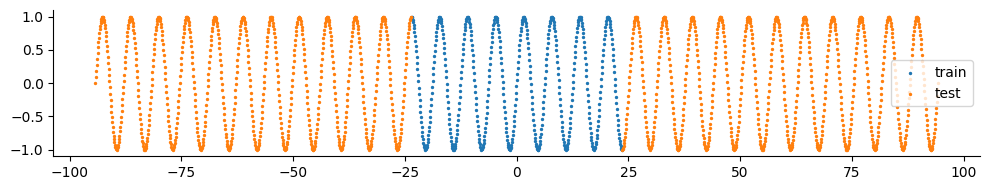

In [20]:
x_train, y_train, x_test, y_test = gen_data(L=2000, start=-30*torch.pi, end=30*torch.pi, reverse=False)

fig, axs = plt.subplots(1, 1, figsize=(10, 2))
plt.scatter(x_train, y_train, label='train', s=2)
plt.scatter(x_test, y_test, label='test', s=2)
plt.legend()
plt.tight_layout()
axs.spines[['right', 'top']].set_visible(False)

In [21]:
count_nodes = 256
lr = 0.001
batch_size = len(x_train) - 1

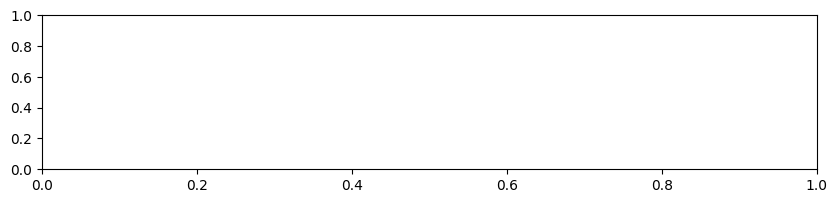

In [22]:
# for animation
fig, axs = plt.subplots(1, 1, figsize=(10, 2)) # dpi=200)

In [23]:
frames = 50
epochs_per_frame = 100

In [ ]:
layernorm = False
resnet=False
emb_loss_beta = 10

model = MLP(count_nodes, resnet)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames,
                               interval=1)
HTML(anim.to_jshtml(fps=15))

tensor(10.5477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.4341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.5327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.8861, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9816, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.5431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1787, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9507, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5122, device='cuda:0', grad_fn=<AddBa

In [15]:
layernorm = False
resnet=False
emb_loss_beta = 2

model = MLP(count_nodes, resnet)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames,
                               interval=1)
HTML(anim.to_jshtml(fps=15))

tensor(13.3720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.5293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1756, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.7047, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.1750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.3054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1605, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.8418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.2402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.8995, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.0418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.4438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.2123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.2297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.1869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.0178, device='cuda:0', 

## Extrapolation Experiment

Now what if we make this an interpolation problem instead of an extrapolation problem. In other words, what if we reverse the train and test set? Will the model be able to infer the sine wave in between the test data? We show below the sine wave colored by train (blue) and test (orange)

In [ ]:
x_train, y_train, x_test, y_test = gen_data(reverse=True)

fig, axs = plt.subplots(1, 1, figsize=(10, 2))
plt.scatter(x_train, y_train, label='train', s=2)
plt.scatter(x_test, y_test, label='test', s=2)
plt.legend()
plt.tight_layout()
axs.spines[['right', 'top']].set_visible(False)

In [ ]:
# for animation
fig, axs = plt.subplots(1, 1, figsize=(10, 2)) # dpi=200)

In [ ]:
count_hidden = 2
count_nodes = 256

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

## Take-aways

## Acknowledgements

Thanks
* Kristian for the resnet idea
* Stan for the embedding similarity idea